In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Nadam


# File paths
DATA_PATHS = {
    "train": "train.csv",
    "clients": "client.csv",
    "gas_prices": "gas_prices.csv",
    "electricity_prices": "electricity_prices.csv",
    "weather_mapping": "weather_station_to_county_mapping.csv",
    "forecast_weather": "forecast_weather.csv",
    "historical_weather": "example_test_files/historical_weather.csv",
}

# Load datasets
train_df = pd.read_csv(DATA_PATHS["train"], parse_dates=["datetime"])
clients_df = pd.read_csv(DATA_PATHS["clients"])
gas_df = pd.read_csv(DATA_PATHS["gas_prices"])
electricity_prices_df = pd.read_csv(DATA_PATHS["electricity_prices"])
weather_station_to_county_mapping_df = pd.read_csv(DATA_PATHS["weather_mapping"])
forecast_weather_df = pd.read_csv(DATA_PATHS["forecast_weather"])
historical_weather_df = pd.read_csv(DATA_PATHS["historical_weather"])

def preprocess_time_data(train_df, forecast_weather_df, historical_weather_df, gas_df, electricity_prices_df):
    # Parse datetime columns
    train_df['datetime'] = pd.to_datetime(train_df['datetime'])
    forecast_weather_df['origin_datetime'] = pd.to_datetime(forecast_weather_df['origin_datetime'])
    forecast_weather_df['forecast_datetime'] = pd.to_datetime(forecast_weather_df['forecast_datetime']) - pd.Timedelta(hours=1)
    historical_weather_df['datetime'] = pd.to_datetime(historical_weather_df['datetime']) - pd.Timedelta(hours=1)
    gas_df['origin_date'] = pd.to_datetime(gas_df['origin_date'])
    gas_df['forecast_date'] = pd.to_datetime(gas_df['forecast_date'])
    electricity_prices_df['origin_date'] = pd.to_datetime(electricity_prices_df['origin_date'])
    electricity_prices_df['forecast_date'] = pd.to_datetime(electricity_prices_df['forecast_date'])

    return train_df, forecast_weather_df, historical_weather_df, gas_df, electricity_prices_df

train_df, forecast_weather_df, historical_weather_df, gas_df, electricity_prices_df = preprocess_time_data(
    train_df, forecast_weather_df, historical_weather_df, gas_df, electricity_prices_df
)

def check_missing_data(dfs, df_names):
    for df, name in zip(dfs, df_names):
        missing = df.isna().sum()
        print(f"Missing data in {name}:")
        print(missing[missing > 0])  # Only display columns with missing data

dfs = [train_df, clients_df, gas_df, electricity_prices_df, forecast_weather_df, historical_weather_df]
df_names = ['train_df', 'clients_df', 'gas_df', 'electricity_prices_df', 'forecast_weather_df', 'historical_weather_df']
check_missing_data(dfs, df_names)

# Drop missing rows (consider replacing with imputation if large data loss occurs)
train_df = train_df.dropna()
forecast_weather_df = forecast_weather_df.dropna()


Missing data in train_df:
target    528
dtype: int64
Missing data in clients_df:
Series([], dtype: int64)
Missing data in gas_df:
Series([], dtype: int64)
Missing data in electricity_prices_df:
Series([], dtype: int64)
Missing data in forecast_weather_df:
surface_solar_radiation_downwards    2
dtype: int64
Missing data in historical_weather_df:
Series([], dtype: int64)


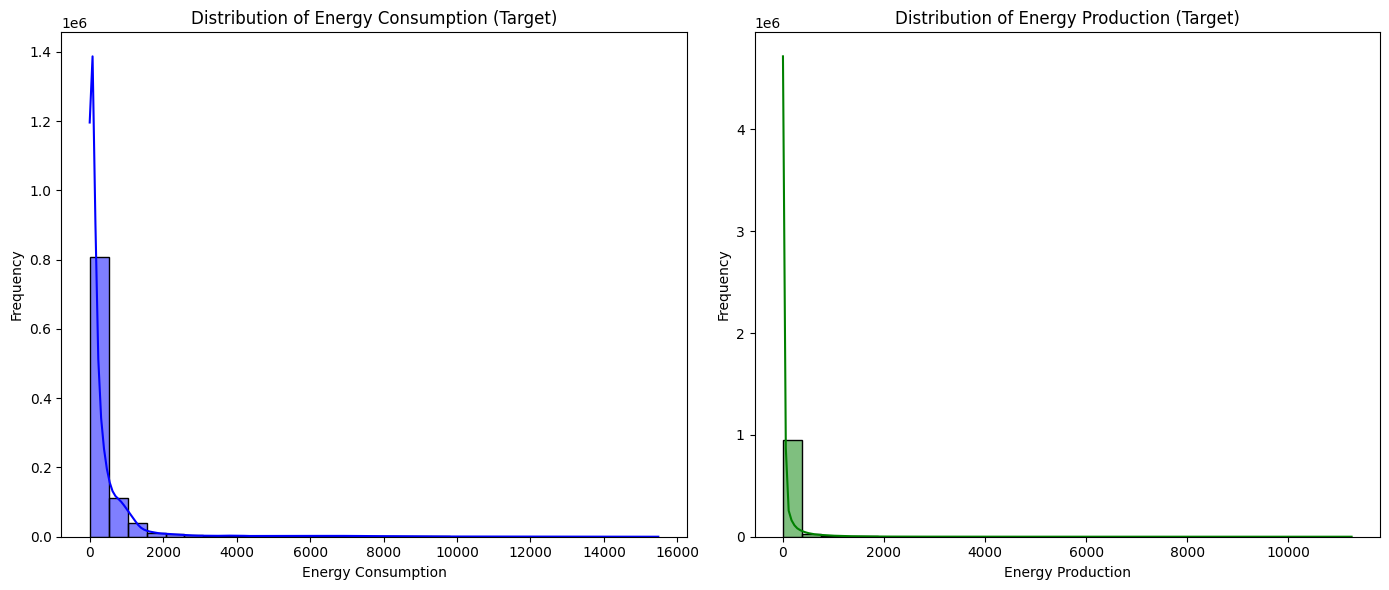

In [3]:
import seaborn as sns 
# Separate consumption and production data
consumption_df = train_df[train_df['is_consumption'] == True]
production_df = train_df[train_df['is_consumption'] == False]

plt.figure(figsize=(14, 6))
# Distribution of consumption
plt.subplot(1, 2, 1)
sns.histplot(consumption_df['target'], kde=True, bins=30, color='blue')
plt.title('Distribution of Energy Consumption (Target)')
plt.xlabel('Energy Consumption')
plt.ylabel('Frequency')

# Distribution of production
plt.subplot(1, 2, 2)
sns.histplot(production_df['target'], kde=True, bins=30, color='green')
plt.title('Distribution of Energy Production (Target)')
plt.xlabel('Energy Production')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

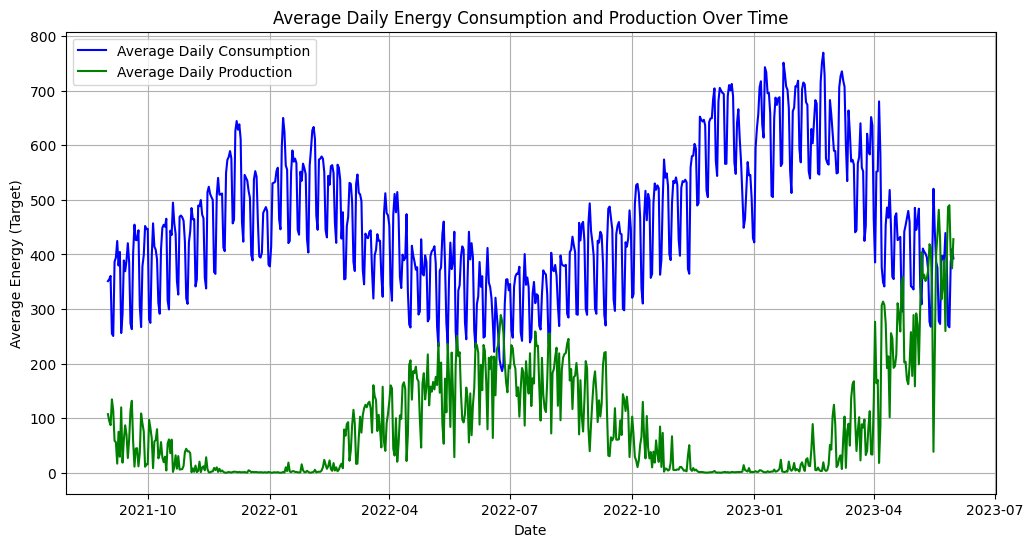

In [4]:
# Separate consumption and production data
consumption_df = train_df[train_df['is_consumption'] == 1]
production_df = train_df[train_df['is_consumption'] == 0]

# Group by date and calculate the mean target (energy) for each day
daily_avg_consumption = consumption_df.resample('D', on='datetime')['target'].mean()
daily_avg_production = production_df.resample('D', on='datetime')['target'].mean()

# Plotting
plt.figure(figsize=(12, 6))

plt.plot(daily_avg_consumption, label='Average Daily Consumption', color='blue')
plt.plot(daily_avg_production, label='Average Daily Production', color='green')

plt.xlabel('Date')
plt.ylabel('Average Energy (Target)')
plt.title('Average Daily Energy Consumption and Production Over Time')
plt.legend()
plt.grid(True)
plt.show()

In [5]:
# Handle mismatched dtypes
clients_df['date'] = pd.to_datetime(clients_df['date'])
historical_weather_df['data_block_id'] = historical_weather_df['data_block_id'].astype('int64')


In [6]:
import pandas as pd
import numpy as np

class ComprehensiveEnergyDataProcessor:
    """Comprehensive processing for energy data with advanced feature engineering."""
    
    def __init__(self, main_data_path, client_path, gas_prices_path, electricity_prices_path, forecast_weather_path, historical_weather_path):
        self.main_data_path = main_data_path
        self.client_path = client_path
        self.gas_prices_path = gas_prices_path
        self.electricity_prices_path = electricity_prices_path
        self.forecast_weather_path = forecast_weather_path
        self.historical_weather_path = historical_weather_path

        # Initialize the dataframes
        self.main_df = None
        self.client = None
        self.gas_prices = None
        self.electricity_prices = None
        self.forecast_weather_df = None
        self.historical_weather_df = None
        
        self.forecast_weather_features = [
            "temperature", "dewpoint", "cloudcover_high", "cloudcover_low",
            "cloudcover_mid", "cloudcover_total", "10_metre_u_wind_component",
            "10_metre_v_wind_component", "data_block_id", "datetime",
            "direct_solar_radiation", "surface_solar_radiation_downwards",
            "snowfall", "total_precipitation", "county"
        ]

    def load_data(self):
        """Load all datasets from CSV files."""
        self.main_df = pd.read_csv(self.main_data_path)
        self.client = pd.read_csv(self.client_path)
        self.gas_prices = pd.read_csv(self.gas_prices_path)
        self.electricity_prices = pd.read_csv(self.electricity_prices_path)
        self.forecast_weather_df = pd.read_csv(self.forecast_weather_path)
        self.historical_weather_df = pd.read_csv(self.historical_weather_path)

    def process_main_data(self):
        """Preprocess the main dataset with advanced feature engineering."""
        self.main_df["datetime"] = pd.to_datetime(self.main_df["datetime"]).dt.floor('H')
        
        # Time-based features
        self.main_df["hour"] = self.main_df["datetime"].dt.hour
        self.main_df["day"] = self.main_df["datetime"].dt.day
        self.main_df["month"] = self.main_df["datetime"].dt.month
        self.main_df["day_of_week"] = self.main_df["datetime"].dt.dayofweek
        self.main_df["year"] = self.main_df["datetime"].dt.year
        self.main_df["is_weekend"] = self.main_df["day_of_week"] >= 5
        
        # Cyclical encoding for time features
        self.main_df['hour_sin'] = np.sin(2 * np.pi * self.main_df['hour'] / 24)
        self.main_df['hour_cos'] = np.cos(2 * np.pi * self.main_df['hour'] / 24)
        self.main_df['day_sin'] = np.sin(2 * np.pi * self.main_df['day'] / 7)
        self.main_df['day_cos'] = np.cos(2 * np.pi * self.main_df['day'] / 7)
        self.main_df['month_sin'] = np.sin(2 * np.pi * self.main_df['month'] / 12)
        self.main_df['month_cos'] = np.cos(2 * np.pi * self.main_df['month'] / 12)

        # Lag features
        for lag in [1, 2, 3, 6]:  
            self.main_df[f"target_lag_{lag}"] = self.main_df.groupby("prediction_unit_id")["target"].shift(lag)
        
        # Rolling statistics
        self.main_df["target_rolling_mean_3"] = self.main_df.groupby("prediction_unit_id")["target"].rolling(window=3).mean().reset_index(level=0, drop=True)
        self.main_df["target_rolling_mean_24"] = self.main_df.groupby("prediction_unit_id")["target"].rolling(window=24).mean().reset_index(level=0, drop=True)
        self.main_df["target_rolling_std_24"] = self.main_df.groupby("prediction_unit_id")["target"].rolling(window=24).std().reset_index(level=0, drop=True)

    def process_gas_prices(self):
        """Preprocess gas prices data."""
        self.gas_prices["origin_date"] = pd.to_datetime(self.gas_prices["origin_date"])
        self.gas_prices["forecast_date"] = pd.to_datetime(self.gas_prices["forecast_date"])

    def process_electricity_prices(self):
        """Preprocess electricity prices data."""
        self.electricity_prices["origin_date"] = pd.to_datetime(self.electricity_prices["origin_date"])
        self.electricity_prices["forecast_date"] = pd.to_datetime(self.electricity_prices["forecast_date"])
        self.electricity_prices["datetime"] = self.electricity_prices["forecast_date"]

    def process_forecast_weather_data(self, weather_station_to_county_mapping_df: pd.DataFrame):
        """Process and enrich forecast weather data."""
        self.forecast_weather_df["latitude"] = self.forecast_weather_df["latitude"].astype(float)
        self.forecast_weather_df["longitude"] = self.forecast_weather_df["longitude"].astype(float)
        self.forecast_weather_df = pd.merge(
            self.forecast_weather_df, 
            weather_station_to_county_mapping_df, 
            on=["latitude", "longitude"], 
            how="left"
        )
        self.forecast_weather_df["datetime"] = pd.to_datetime(self.forecast_weather_df["forecast_datetime"]).dt.floor('H')

    def merge_data(self):
        """Merge all datasets into the main dataframe."""
        # Merge client data
        self.main_df = self.main_df.merge(
            self.client[["county", "is_business", "product_type", "installed_capacity", "eic_count", "data_block_id"]], 
            how="left", 
            on=["county", "is_business", "product_type", "data_block_id"]
        )
        
        # Merge gas prices
        self.main_df = self.main_df.merge(
            self.gas_prices[["data_block_id", "forecast_date", "lowest_price_per_mwh", "highest_price_per_mwh"]], 
            how="left", 
            on="data_block_id"
        )

        # Merge electricity prices
        self.main_df = self.main_df.merge(
            self.electricity_prices[["datetime", "euros_per_mwh"]], 
            how="left",
            on="datetime"
        )
        
        # Merge weather data
        self.main_df = self.main_df.merge(
            self.forecast_weather_df[self.forecast_weather_features], 
            how="inner",
            on=["data_block_id", "datetime", "county"]
        )

    def process_all(self, weather_station_to_county_mapping_df):
        """Execute the entire data processing pipeline."""
        self.load_data()
        self.process_main_data()
        self.process_gas_prices()
        self.process_electricity_prices()
        self.process_forecast_weather_data(weather_station_to_county_mapping_df)
        self.merge_data()
        return self.main_df


In [7]:
# Initialize processor
processor = ComprehensiveEnergyDataProcessor("train.csv",
                                "client.csv",
                                "gas_prices.csv",
                                "electricity_prices.csv",
                                "forecast_weather.csv",
                                "historical_weather.csv"
                               )

pro_df = processor.process_all(weather_station_to_county_mapping_df)

C:\Users\johnn\AppData\Local\Temp\ipykernel_20504\1268160289.py:42: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  self.main_df["datetime"] = pd.to_datetime(self.main_df["datetime"]).dt.floor('H')
C:\Users\johnn\AppData\Local\Temp\ipykernel_20504\1268160289.py:90: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  self.forecast_weather_df["datetime"] = pd.to_datetime(self.forecast_weather_df["forecast_datetime"]).dt.floor('H')


In [8]:
pro_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1956474 entries, 0 to 1956473
Data columns (total 46 columns):
 #   Column                             Dtype         
---  ------                             -----         
 0   county                             int64         
 1   is_business                        int64         
 2   product_type                       int64         
 3   target                             float64       
 4   is_consumption                     int64         
 5   datetime                           datetime64[ns]
 6   data_block_id                      int64         
 7   row_id                             int64         
 8   prediction_unit_id                 int64         
 9   hour                               int32         
 10  day                                int32         
 11  month                              int32         
 12  day_of_week                        int32         
 13  year                               int32         
 14  is

In [9]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, LSTM, Bidirectional, Dense, Dropout, TimeDistributed, RepeatVector
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt
import matplotlib.pyplot as plt

# Load and preprocess data
X = pro_df.drop(columns=["target", "datetime", "data_block_id", "row_id", "prediction_unit_id", "forecast_date"])
y = pro_df['target']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

# Remove NaN values
X_train = X_train.dropna()
X_test = X_test.dropna()
y_train = y_train[X_train.index]
y_test = y_test[X_test.index]

# Scale the features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape for LSTM
X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))


In [12]:
# Hyperparameter Tuning
def build_model(hp):
    inputs = Input(shape=(1, X_train_reshaped.shape[2]))
    
    # Conv1D layers
    x = Conv1D(filters=hp.Int('filters', 64, 128, step=64),
               kernel_size=4, activation='relu', padding='causal')(inputs)
    x = Conv1D(filters = hp.Int('filters' , 64, 128, step=64), kernel_size=3, activation='relu', padding='causal')(x)
    x = Dropout(hp.Float('dropout', 0.1, 0.4, step=0.1))(x)
    
    # Bidirectional LSTM
    x = Bidirectional(LSTM(hp.Int('lstm_units', 64, 256, step=64)))(x)
    x = RepeatVector(1)(x)
    x = LSTM(hp.Int('decoder_lstm_units', 64, 256, step=64), return_sequences=True)(x)
    
    outputs = TimeDistributed(Dense(1))(x)
    
    model = Model(inputs, outputs)
    
    # Optimizer
    optimizer = tf.keras.optimizers.RMSprop(learning_rate=hp.Float('lr', 1e-3, 1e-2, sampling='log'))
    model.compile(optimizer=optimizer, loss='mae')
    return model

# Initialize Keras Tuner
tuner = kt.BayesianOptimization(
    build_model,
    objective='val_loss',
    max_trials=10,
    directory='keras_tuner_dir',
    project_name='time_series_forecasting'
)

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Tune hyperparameters
tuner.search(X_train_reshaped, y_train, epochs=20, validation_split=0.2, callbacks=[early_stopping],batch_size=96)

# Best model
best_hps = tuner.get_best_hyperparameters(1)[0]
best_model = tuner.hypermodel.build(best_hps)


Trial 10 Complete [00h 25m 35s]
val_loss: 15.131263732910156

Best val_loss So Far: 9.414755821228027
Total elapsed time: 05h 33m 09s


In [16]:
# TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=3)

mae_scores = []
for train_idx, val_idx in tscv.split(X_train_reshaped):
    X_train_fold, X_val_fold = X_train_reshaped[train_idx], X_train_reshaped[val_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    history = best_model.fit(X_train_fold, y_train_fold, 
                             validation_data=(X_val_fold, y_val_fold), 
                             epochs=60, 
                             batch_size=96, 
                             callbacks=[early_stopping],
                             verbose=1)
    
    val_loss = history.history['val_loss'][-1]
    mae_scores.append(val_loss)

print(f"Average MAE across folds: {np.mean(mae_scores)}")

Epoch 1/60
4042/4042 [==============================] - 50s 12ms/step - loss: 11.7648 - val_loss: 10.6149
Epoch 2/60
4042/4042 [==============================] - 50s 12ms/step - loss: 11.5465 - val_loss: 16.0651
Epoch 3/60
4042/4042 [==============================] - 52s 13ms/step - loss: 11.4991 - val_loss: 13.7284
Epoch 4/60
4042/4042 [==============================] - 51s 13ms/step - loss: 11.2969 - val_loss: 14.7634
Epoch 5/60
4042/4042 [==============================] - 50s 12ms/step - loss: 11.1364 - val_loss: 10.5436
Epoch 6/60
4042/4042 [==============================] - 50s 12ms/step - loss: 11.1216 - val_loss: 13.6544
Epoch 7/60
4042/4042 [==============================] - 50s 12ms/step - loss: 11.0968 - val_loss: 10.8017
Epoch 8/60
4042/4042 [==============================] - 51s 13ms/step - loss: 11.0206 - val_loss: 9.5648
Epoch 9/60
4042/4042 [==============================] - 51s 13ms/step - loss: 11.1591 - val_loss: 12.9069
Epoch 10/60
4042/4042 [========================

12126/12126 [==============================] - 29s 2ms/step
Test MAE: 8.436684162819791


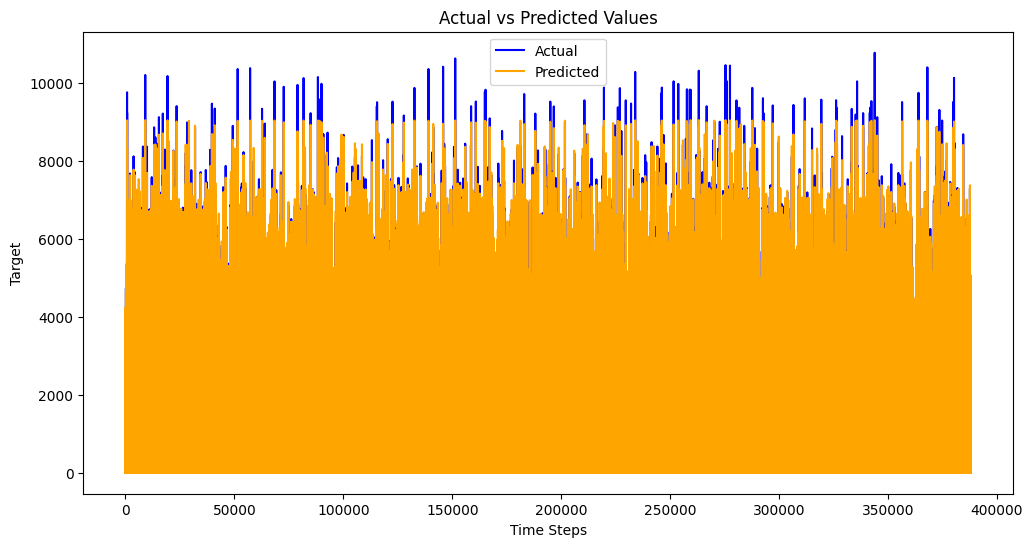

In [17]:
# Evaluate on test data
y_pred = best_model.predict(X_test_reshaped).flatten()

# MAE calculation
mae = np.mean(np.abs(y_test - y_pred))
print(f"Test MAE: {mae}")

# Visualization
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='Actual', color='blue')
plt.plot(y_pred, label='Predicted', color='orange')
plt.title('Actual vs Predicted Values')
plt.xlabel('Time Steps')
plt.ylabel('Target')
plt.legend()
plt.show()
